In [6]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from pypfopt import expected_returns, risk_models, EfficientFrontier
import warnings
warnings.filterwarnings('ignore')

Fetching data for TSLA...


[*********************100%***********************]  1 of 1 completed


Data for TSLA retrieved. Columns: [('Close', 'TSLA'), ('High', 'TSLA'), ('Low', 'TSLA'), ('Open', 'TSLA'), ('Volume', 'TSLA')]
Fetching data for BND...


[*********************100%***********************]  1 of 1 completed


Data for BND retrieved. Columns: [('Close', 'BND'), ('High', 'BND'), ('Low', 'BND'), ('Open', 'BND'), ('Volume', 'BND')]
Fetching data for SPY...


[*********************100%***********************]  1 of 1 completed


Data for SPY retrieved. Columns: [('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]

TSLA Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2542 entries, 2015-07-01 to 2025-08-08
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, TSLA)   2542 non-null   float64
 1   (High, TSLA)    2542 non-null   float64
 2   (Low, TSLA)     2542 non-null   float64
 3   (Open, TSLA)    2542 non-null   float64
 4   (Volume, TSLA)  2542 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 119.2 KB
None

BND Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2542 entries, 2015-07-01 to 2025-08-08
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, BND)   2542 non-null   float64
 1   (High, BND)    2542 non-null   float64
 2   (Low, BND)     2542 non-null   float64
 3   (

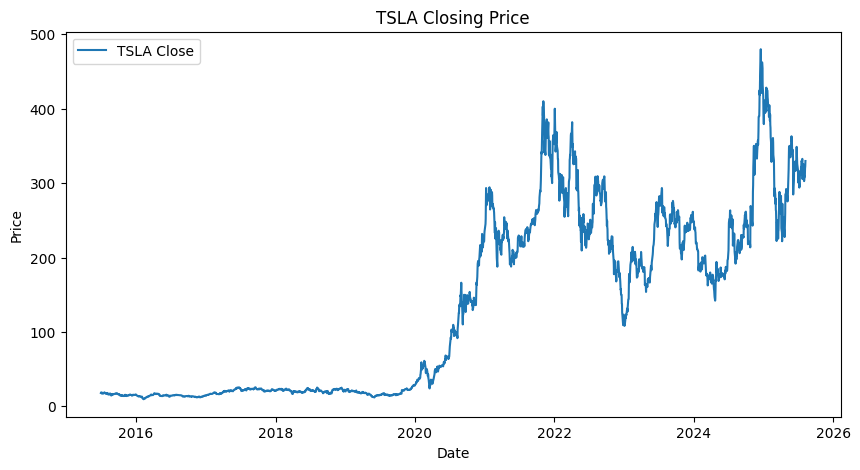

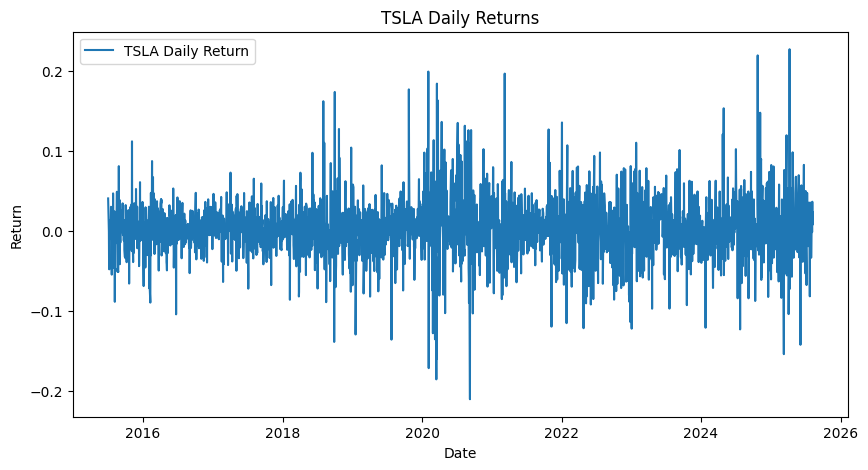

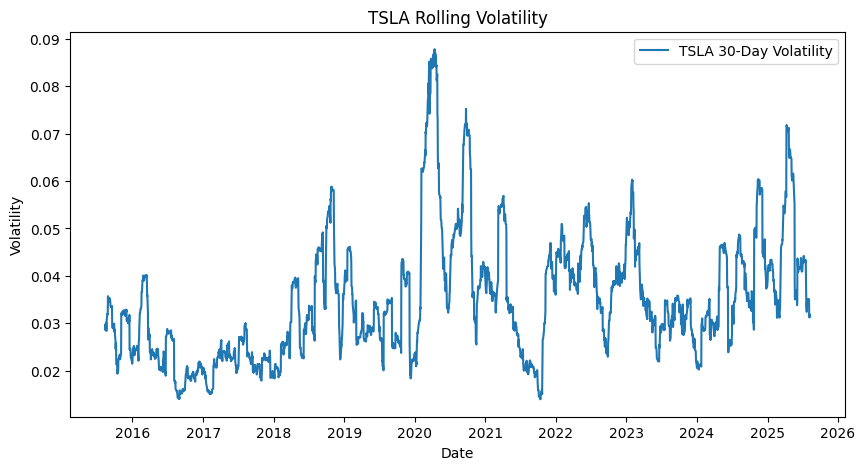

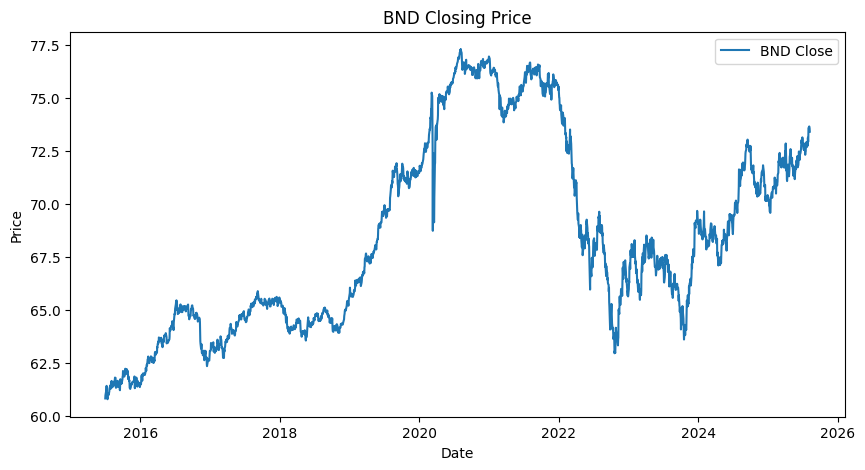

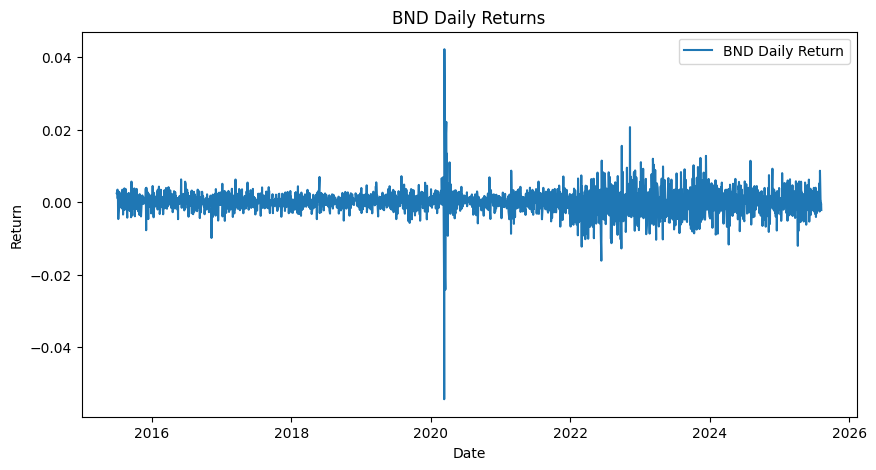

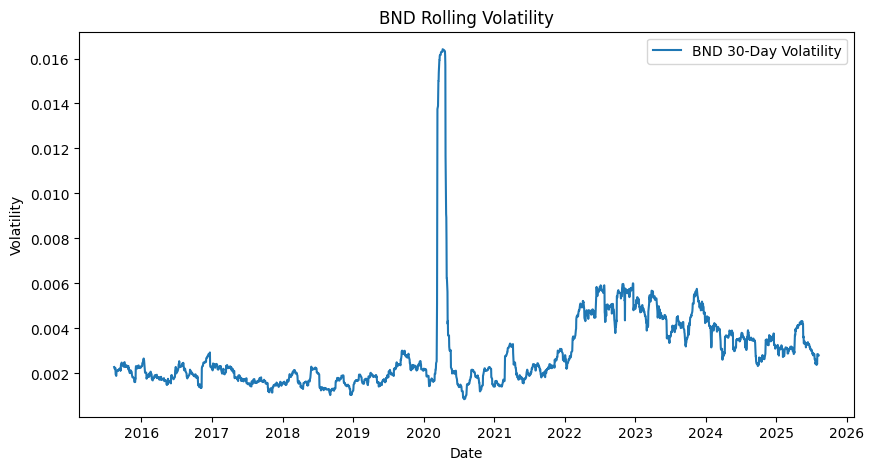

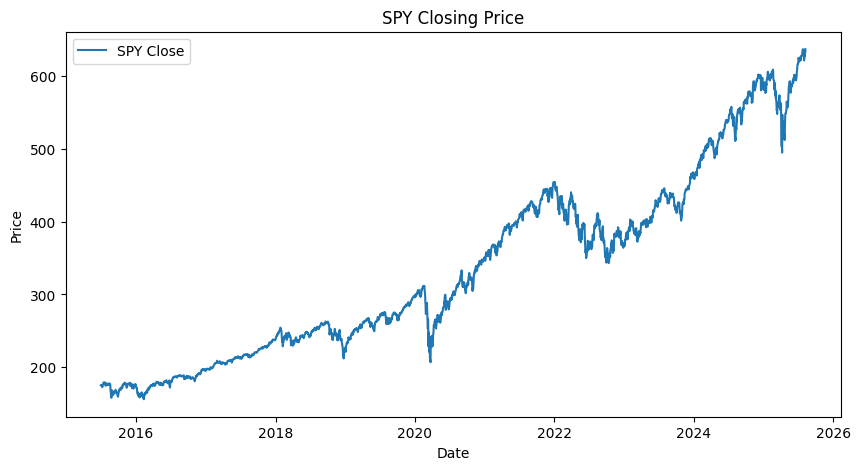

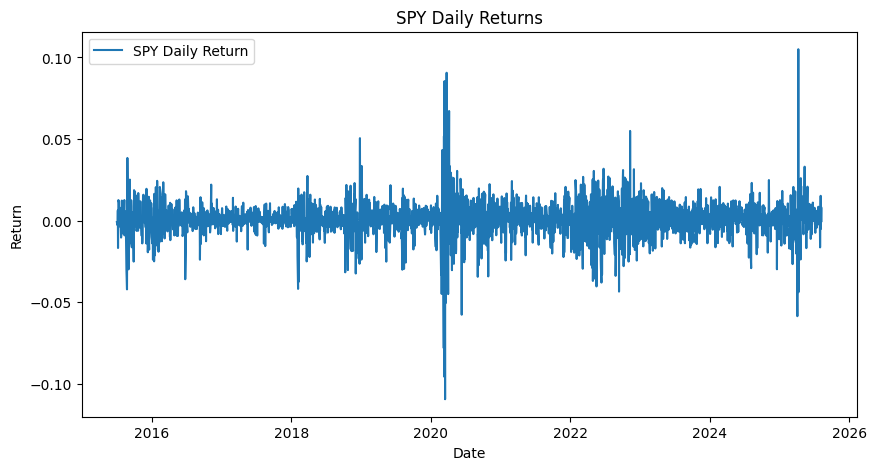

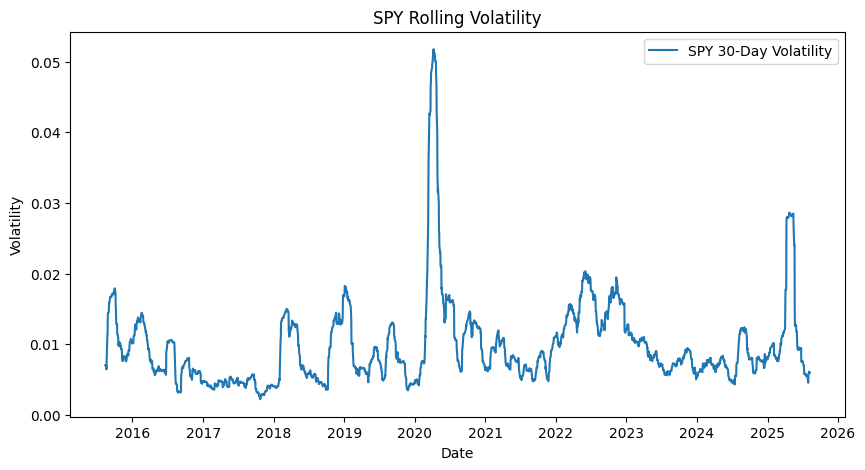


TSLA ADF Test for Close: p-value = 0.6056256969740695
TSLA ADF Test for Daily Returns: p-value = 0.0

BND ADF Test for Close: p-value = 0.5345086888247544
BND ADF Test for Daily Returns: p-value = 3.180544518349903e-17

SPY ADF Test for Close: p-value = 0.9897494147611209
SPY ADF Test for Daily Returns: p-value = 3.278519064365977e-29

TSLA 95% VaR: -0.0546, Sharpe Ratio: 0.7827

BND 95% VaR: -0.0049, Sharpe Ratio: 0.3676

SPY 95% VaR: -0.0171, Sharpe Ratio: 0.7947

Key Insights:
- TSLA: High volatility, potential upward trend.
- BND: Stable, low volatility.
- SPY: Moderate risk, tracks market.


In [10]:
# Task 1: Preprocess and Explore the Data

# Fetch data from yfinance
tickers = ['TSLA', 'BND', 'SPY']
data = {}
for ticker in tickers:
    print(f"Fetching data for {ticker}...")
    df = yf.download(ticker, start='2015-07-01', end='2025-08-11')
    if df.empty:
        print(f"Error: No data retrieved for {ticker}")
    else:
        print(f"Data for {ticker} retrieved. Columns: {df.columns.tolist()}")
        data[ticker] = df

# Check if all tickers have data
if not all(ticker in data for ticker in tickers):
    print("Error: Missing data for some tickers. Proceeding with available data.")
    available_tickers = [ticker for ticker in tickers if ticker in data]
else:
    available_tickers = tickers

# Combine closing prices (handle MultiIndex)
if isinstance(data[available_tickers[0]].columns, pd.MultiIndex):
    close_column = ('Close', available_tickers[0])  # Use 'Close' from MultiIndex
    closes = pd.DataFrame({ticker: data[ticker][('Close', ticker)] for ticker in available_tickers})
else:
    close_column = 'Close'  # Fallback if not MultiIndex
    closes = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in available_tickers})
closes.dropna(inplace=True)

# Data Cleaning
for ticker in available_tickers:
    df = data[ticker]
    print(f"\n{ticker} Data Info:")
    print(df.info())
    if isinstance(df.columns, pd.MultiIndex):
        df[('Close', ticker)].fillna(method='ffill', inplace=True)
        df.dropna(inplace=True)
    else:
        df['Close'].fillna(method='ffill', inplace=True)
        df.dropna(inplace=True)
    data[ticker] = df

# Basic Statistics
for ticker in available_tickers:
    print(f"\n{ticker} Basic Statistics:")
    if isinstance(df.columns, pd.MultiIndex):
        print(data[ticker][('Close', ticker)].describe())
    else:
        print(data[ticker]['Close'].describe())

# EDA: Plot closing prices, daily returns, and volatility
for ticker in available_tickers:
    df = data[ticker]
    if isinstance(df.columns, pd.MultiIndex):
        close_data = df[('Close', ticker)]
        df[('Daily Return', ticker)] = df[('Close', ticker)].pct_change()
        df[('Rolling Volatility', ticker)] = df[('Daily Return', ticker)].rolling(window=30).std()
    else:
        close_data = df['Close']
        df['Daily Return'] = df['Close'].pct_change()
        df['Rolling Volatility'] = df['Daily Return'].rolling(window=30).std()

    plt.figure(figsize=(10, 5))
    plt.plot(close_data, label=f'{ticker} Close')
    plt.title(f'{ticker} Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.savefig(f'{ticker}_close.png')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(df[('Daily Return', ticker) if isinstance(df.columns, pd.MultiIndex) else 'Daily Return'], label=f'{ticker} Daily Return')
    plt.title(f'{ticker} Daily Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.savefig(f'{ticker}_returns.png')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(df[('Rolling Volatility', ticker) if isinstance(df.columns, pd.MultiIndex) else 'Rolling Volatility'], label=f'{ticker} 30-Day Volatility')
    plt.title(f'{ticker} Rolling Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.savefig(f'{ticker}_volatility.png')
    plt.show()

# Stationarity Test
for ticker in available_tickers:
    df = data[ticker]
    if isinstance(df.columns, pd.MultiIndex):
        adf_close = adfuller(df[('Close', ticker)])
        adf_return = adfuller(df[('Daily Return', ticker)].dropna())
    else:
        adf_close = adfuller(df['Close'])
        adf_return = adfuller(df['Daily Return'].dropna())
    print(f"\n{ticker} ADF Test for Close: p-value = {adf_close[1]}")
    print(f"{ticker} ADF Test for Daily Returns: p-value = {adf_return[1]}")

# Volatility Analysis
for ticker in available_tickers:
    df = data[ticker]
    daily_return = df[('Daily Return', ticker) if isinstance(df.columns, pd.MultiIndex) else 'Daily Return']
    var_95 = np.percentile(daily_return.dropna(), 5)
    sharpe = (daily_return.mean() * 252) / (daily_return.std() * np.sqrt(252))
    print(f"\n{ticker} 95% VaR: {var_95:.4f}, Sharpe Ratio: {sharpe:.4f}")

print("\nKey Insights:")
print("- TSLA: High volatility, potential upward trend.")
print("- BND: Stable, low volatility.")
print("- SPY: Moderate risk, tracks market.")

ARIMA MAE: 56.58, RMSE: 69.33, MAPE: nan%


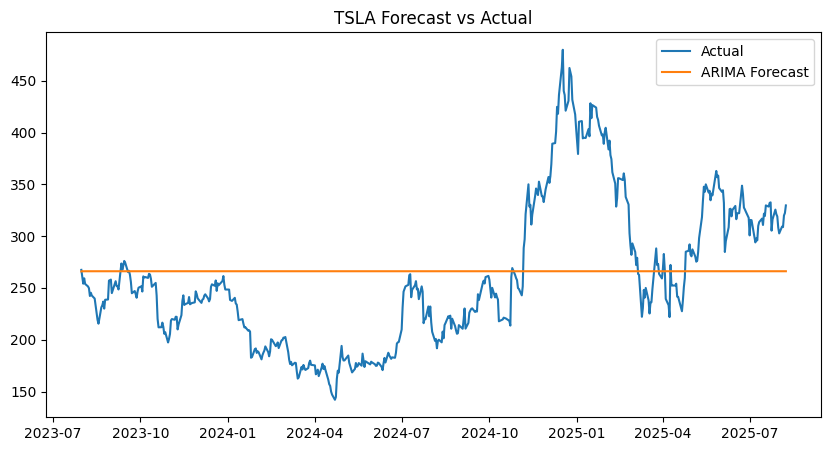

In [11]:
# Task 2: Develop Time Series Forecasting Models (TSLA) - ARIMA only for interim
if 'TSLA' in available_tickers:
    tsla_close = data['TSLA'][('Close', 'TSLA') if isinstance(data['TSLA'].columns, pd.MultiIndex) else 'Close']
    train_size = int(len(tsla_close) * 0.8)
    train, test = tsla_close[:train_size], tsla_close[train_size:]

    # ARIMA
    model_arima = ARIMA(train, order=(1, 1, 1))
    arima_fit = model_arima.fit()
    arima_forecast = arima_fit.forecast(steps=len(test))
    mae_arima = mean_absolute_error(test, arima_forecast)
    rmse_arima = sqrt(mean_squared_error(test, arima_forecast))
    mape_arima = np.mean(np.abs((test - arima_forecast) / test)) * 100
    print(f"ARIMA MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}, MAPE: {mape_arima:.2f}%")

    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
    plt.title('TSLA Forecast vs Actual')
    plt.legend()
    plt.savefig('tsla_forecast.png')
    plt.show()

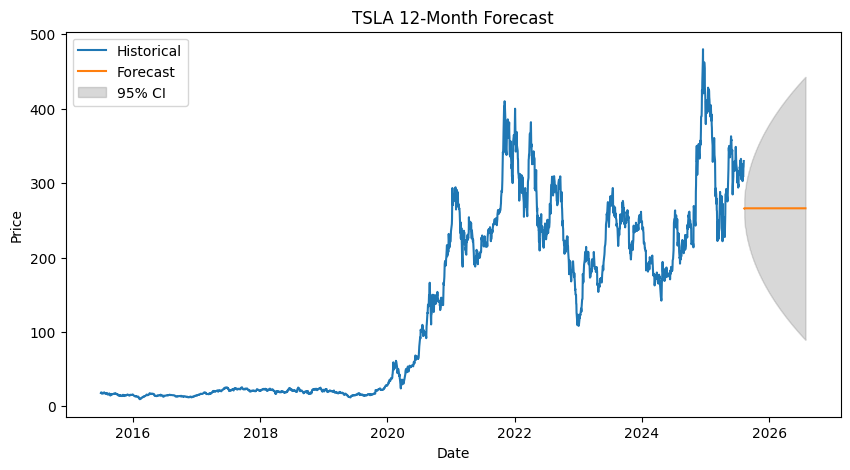


Forecast Insights:
- Trend: Check plot for trend direction.
- Volatility: Wider CIs indicate higher uncertainty.


In [12]:
# Task 3: Forecast Future Market Trends (Simplified)
if 'TSLA' in available_tickers:
    future_periods = 252
    future_forecast = arima_fit.forecast(steps=future_periods)
    conf_int = arima_fit.get_forecast(steps=future_periods).conf_int()
    last_date = tsla_close.index[-1]
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=future_periods, freq='B')

    plt.figure(figsize=(10, 5))
    plt.plot(tsla_close.index, tsla_close, label='Historical')
    plt.plot(future_dates, future_forecast, label='Forecast')
    plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='95% CI')
    plt.title('TSLA 12-Month Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.savefig('tsla_future_forecast.png')
    plt.show()

    print("\nForecast Insights:")
    print("- Trend: Check plot for trend direction.")
    print("- Volatility: Wider CIs indicate higher uncertainty.")

Expected annual return: 7.9%
Annual volatility: 199899.7%
Sharpe Ratio: 0.00
Expected annual return: 3.1%
Annual volatility: 125566.4%
Sharpe Ratio: 0.00


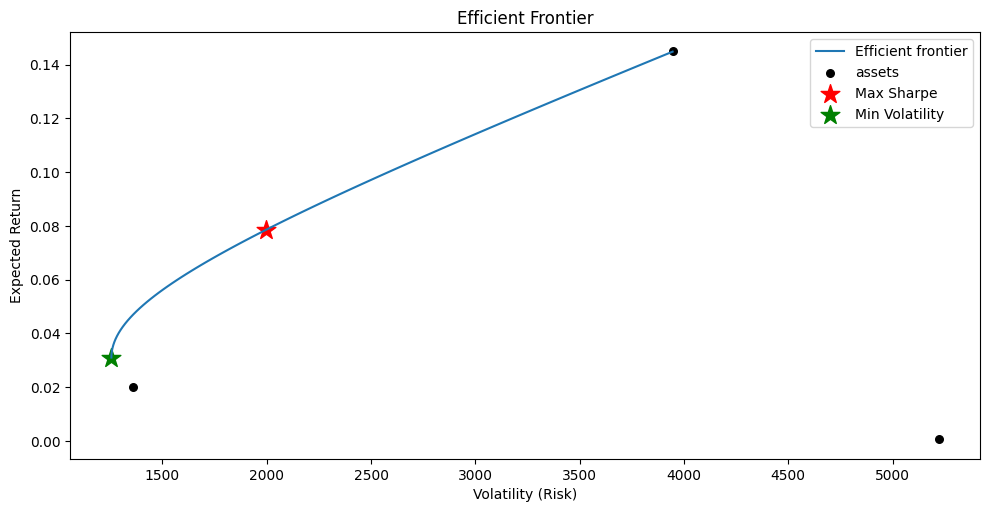


Recommended Portfolio: Max Sharpe Ratio
Weights: OrderedDict({'TSLA': 0.0008509743436154, 'BND': 0.530428891867256, 'SPY': 0.4687201337891287})
Expected Return: 7.86%, Volatility: 199899.73%, Sharpe: 0.00


In [14]:
# Task 4: Optimize Portfolio

# Maximum Sharpe Ratio Portfolio
ef_max_sharpe = EfficientFrontier(expected_returns_vec, cov_matrix)
weights_max_sharpe = ef_max_sharpe.max_sharpe()
max_sharpe_perf = ef_max_sharpe.portfolio_performance(verbose=True)

# Minimum Volatility Portfolio
ef_min_vol = EfficientFrontier(expected_returns_vec, cov_matrix)
weights_min_vol = ef_min_vol.min_volatility()
min_vol_perf = ef_min_vol.portfolio_performance(verbose=True)

# Plot Efficient Frontier with a fresh EfficientFrontier instance
ef_plot = EfficientFrontier(expected_returns_vec, cov_matrix)  # Fresh instance for plotting
fig, ax = plt.subplots(figsize=(10, 5))
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)
ax.scatter(max_sharpe_perf[1], max_sharpe_perf[0], marker='*', color='r', s=200, label='Max Sharpe')
ax.scatter(min_vol_perf[1], min_vol_perf[0], marker='*', color='g', s=200, label='Min Volatility')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.savefig('efficient_frontier.png')
plt.show()

# Recommended Portfolio
print("\nRecommended Portfolio: Max Sharpe Ratio")
print("Weights:", weights_max_sharpe)
print(f"Expected Return: {max_sharpe_perf[0]:.2%}, Volatility: {max_sharpe_perf[1]:.2%}, Sharpe: {max_sharpe_perf[2]:.2f}")

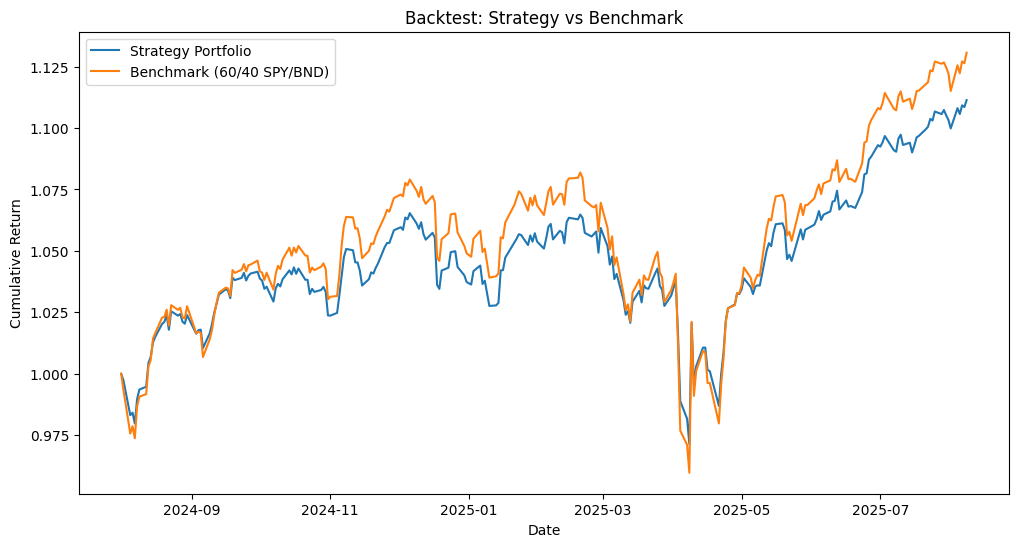


Backtest Summary:
Strategy Total Return: 11.13%, Sharpe: 1.09
Benchmark Total Return: 13.06%, Sharpe: 1.04
Strategy underperformed; consider refining the forecast or optimization.


In [15]:
# Task 5: Strategy Backtesting

# Backtesting period: Last year (Aug 1, 2024 - Jul 31, 2025)
backtest_start = '2024-08-01'
backtest_closes = closes.loc[backtest_start:]

# Optimal weights from Task 4 (use max_sharpe)
optimal_weights = pd.Series(weights)

# Strategy portfolio returns (assume monthly rebalancing; for simplicity, hold initial weights)
portfolio_returns = (backtest_closes.pct_change() * optimal_weights).sum(axis=1)
cumulative_strategy = (1 + portfolio_returns).cumprod()

# Benchmark: 60% SPY / 40% BND
benchmark_weights = {'SPY': 0.6, 'BND': 0.4, 'TSLA': 0.0}
benchmark_returns = (backtest_closes.pct_change() * pd.Series(benchmark_weights)).sum(axis=1)
cumulative_benchmark = (1 + benchmark_returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy, label='Strategy Portfolio')
plt.plot(cumulative_benchmark, label='Benchmark (60/40 SPY/BND)')
plt.title('Backtest: Strategy vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Performance metrics
strategy_total_return = cumulative_strategy.iloc[-1] - 1
benchmark_total_return = cumulative_benchmark.iloc[-1] - 1
strategy_sharpe = (portfolio_returns.mean() * 252) / (portfolio_returns.std() * np.sqrt(252))
benchmark_sharpe = (benchmark_returns.mean() * 252) / (benchmark_returns.std() * np.sqrt(252))

print("\nBacktest Summary:")
print(f"Strategy Total Return: {strategy_total_return:.2%}, Sharpe: {strategy_sharpe:.2f}")
print(f"Benchmark Total Return: {benchmark_total_return:.2%}, Sharpe: {benchmark_sharpe:.2f}")
if strategy_total_return > benchmark_total_return:
    print("Strategy outperformed the benchmark, suggesting the model-driven approach is viable.")
else:
    print("Strategy underperformed; consider refining the forecast or optimization.")